In [28]:
%matplotlib inline

In [29]:
# coding: utf-8

# TODO: replace paths to mmaped files

import time
import sys

import astra
import numpy as np
import pylab as plt
import numexpr

In [30]:
def create_test_cube(size):
    '''
    Create a simple hollow cube phantom

    :param size: Cube size length (int >0)
    :return: numpy mmaped array cube
    '''
#     cube = np.zeros((size,size,size), dtype='float32')
    cube = np.memmap('/diskmnt/fast/makov/cube.tmp',
                     dtype='float32', mode='w+', shape=(size, size, size))
    x0 = int(128.*size/1024)
    x1 = int(895.*size/1024)
    y0 = int(256.*size/1024)
    y1 = int(767.*size/1024)
    cube[x0:x1, x0:x1, x0:x1] = 1
    cube[y0:y1, y0:y1, y0:y1, ] = 0
    return cube


def build_geometry(angles, rec_size):
    """
    Build astra circular geometry for square detector.  See example #5 from python samples

    :params angles_count:List of angles in radians
    :param rec_size: Size of reconstruction volume
    """

    # All distances in [pixels] (MMC1 dataset configuration)

    pixel_size = 2.82473e-3
    os_distance = 56.135 / pixel_size  # object-sample distance
    ds_distance = 225.082 / pixel_size  # detector-sample distance
    detector_size = rec_size

    # Circular

    # Parameters: width of detector column, height of detector row, #rows, #columns,
    #             angles, distance source-origin, distance origin-detector

    proj_geom = astra.create_proj_geom('cone', ds_distance / os_distance, ds_distance / os_distance,
                                       detector_size, detector_size, angles,
                                       os_distance, (ds_distance - os_distance))
    return proj_geom


def create_sino3d_gpu_mm(data, proj_geom, vol_geom, returnData=True, gpuIndex=None, sinogram_volume=None):
    """Create a forward projection of an image (3D).

    :param data: Image data or ID.
    :type data: :class:`numpy.ndarray` or :class:`int`
    :param proj_geom: Projection geometry.
    :type proj_geom: :class:`dict`
    :param vol_geom: Volume geometry.
    :type vol_geom: :class:`dict`
    :param returnData: If False, only return the ID of the forward projection.
    :type returnData: :class:`bool`
    :param gpuIndex: Optional GPU index.
    :type gpuIndex: :class:`int`
    :returns: :class:`int` or (:class:`int`, :class:`numpy.ndarray`) -- If ``returnData=False``, returns the ID of the forward projection. Otherwise, returns a tuple containing the ID of the forward projection and the forward projection itself, in that order.

    """

    if isinstance(data, np.ndarray):
        volume_id = astra.data3d.link('-vol', vol_geom, data)
    else:
        volume_id = data

    if isinstance(sinogram_volume, np.ndarray):
        sino_id = astra.data3d.link('-sino', proj_geom, sinogram_volume)
    else:
        sino_id = astra.data3d.create('-sino', proj_geom, 0)

    algString = 'FP3D_CUDA'
    cfg = astra.astra_dict(algString)
    if gpuIndex is not None:
        cfg['option'] = {'GPUindex': gpuIndex}
    cfg['ProjectionDataId'] = sino_id
    cfg['VolumeDataId'] = volume_id
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)
    astra.algorithm.delete(alg_id)

    if isinstance(data, np.ndarray):
        astra.data3d.delete(volume_id)
    if returnData:
        return sino_id, astra.data3d.get(sino_id)
    else:
        return sino_id


def test_reconstruction_cone_fdk(size, angles_count, gpus_list):
    """
    Build test object, sinogram and reconstrucion
    See http://www.astra-toolbox.com/docs/index.html for other odcs

    :param size: Size of reconstruction volume
    :params angles_count: Number of angles in range 0-PI
    :params gpus_list: list of GPU to use for reconstruction, usually [0,] or [1,] or [0,1]
    """
    # Set up multi-GPU usage.
    # This only works for 3D GPU forward projection and back projection.
    astra.astra.set_gpu_index(gpus_list)

    angles = np.linspace(0, np.pi, angles_count, False)
#     angles = angles-(angles.max()+angles.min())/2

    print('Creating phantom')
    t = time.time()
    # Create a simple hollow cube phantom
    cube = create_test_cube(size)

    # Create projection geometry
    proj_geom = build_geometry(angles, cube.shape[0])

    # Create volume desscription
    vol_geom = astra.create_vol_geom(cube.shape)

    # Upload data to ASTRA
    cube_id = astra.data3d.link('-vol', vol_geom, cube)

    print(time.time() - t)
    print('Creating sinogram')
    t = time.time()
    # Create mmapfile for sinogram
    sinogram_volume = np.memmap('/diskmnt/fast/makov/sinogram.tmp',
                                dtype='float32', mode='w+',
                                shape=(cube.shape[0], len(angles), cube.shape[1]))  # TODO: check for non cube

    # Create sinogram from cube and NOT send data to scipt
    proj_id = create_sino3d_gpu_mm(cube_id, proj_geom, vol_geom,
                                   returnData=False, sinogram_volume=sinogram_volume)

    astra.data3d.delete(cube_id)
    del cube

    print(time.time() - t)
    print('Creating volume')
    t = time.time()

    # To get data by id
    # projection_data = astra.data3d.get(proj_id)
    rec_volume = np.memmap('/diskmnt/fast/makov/rec.tmp',
                           dtype='float32', mode='w+',
                           shape=(vol_geom['GridRowCount'],   # TODO: check for non cube
                                  vol_geom['GridColCount'],
                                  vol_geom['GridSliceCount'])
                           )
    rec_id = astra.data3d.link('-vol', vol_geom, rec_volume)
    # Set up the parameters for a reconstruction algorithm using the GPU
    # Complete list of suporteed algoritms can be found
    # http://www.astra-toolbox.com/docs/algs/index.html
    print(time.time() - t)
    print('Start reconstruction')
    t = time.time()
    cfg = astra.astra_dict('CGLS3D_CUDA')
#     cfg = astra.astra_dict('FDK_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = proj_id
    cfg['option'] = {'ShortScan': True}

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # For FDK number of iterationa my be 1
    astra.algorithm.run(alg_id,3)

    print('Stop reconstruction')
    print(time.time() - t)
#     rec = astra.data3d.get(rec_id)
#     plt.figure()
#     plt.imshow(rec[:,:,int(rec.shape[-1]/2)], cmap=plt.cm.jet)
#     plt.show()

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.data3d.info()
    astra.algorithm.delete(alg_id)
    astra.data3d.delete(proj_id)
    astra.data3d.delete(rec_id)
#     del rec_volume
#     del sinogram_volume
    return rec_volume,sinogram_volume, angles, proj_geom

Creating phantom
0.00795483589172
Creating sinogram
0.0544822216034
Creating volume
0.00594806671143
Start reconstruction
Stop reconstruction
0.0545790195465
id  init  description
-----------------------------------------
7 	v     100x100x100 sinogram data 	
9 	v     100x100x100 volume data 	
26 	v     100x100x100 sinogram data 	
54 	v     100x100x100 sinogram data 	
56 	v     100x100x100 volume data 	
-----------------------------------------

0.161195039749


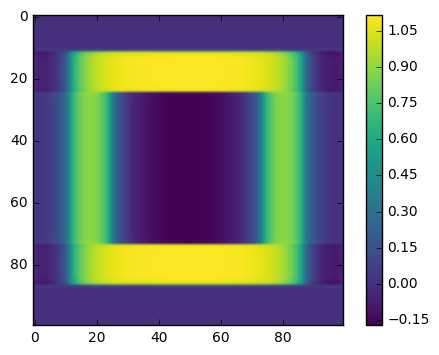

In [27]:
t = time.time()
rec_volume,sinogram_volume, angles, proj_geom = test_reconstruction_cone_fdk(
    size=100, angles_count=100, gpus_list=[0,1])
print(time.time() - t)

# # load and show reconstruction cut
# rec_volume = np.memmap('/diskmnt/fast/makov/rec.tmp',
#                        dtype='float32', mode='r',
#                        shape=(200, 200, 200)
#                        )

plt.figure()
plt.imshow(rec_volume[:, :, int(rec_volume.shape[-1] / 2)],
           cmap=plt.cm.viridis)

plt.colorbar()
plt.show()

In [5]:
print rec_volume.nbytes/1e9
print sinogram_volume.nbytes/1e9

0.004
0.004


In [6]:
def performFP(proj_id, rec_id):
    cfg = astra.astra_dict('FP3D_CUDA')
    cfg['ProjectionDataId'] = proj_id
    cfg['VolumeDataId']     = rec_id
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)
    astra.algorithm.delete(alg_id)

def performBP(proj_id, rec_id):
    cfg = astra.astra_dict('BP3D_CUDA')
    cfg['ProjectionDataId']     = proj_id
    cfg['ReconstructionDataId'] = rec_id
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)
    astra.algorithm.delete(alg_id)

In [26]:
def test_reconstruction_cone_sirt(rec_volume,rec_volume_tmp, sinogram_volume, angles, proj_geom, gpus_list):
    astra.astra.set_gpu_index(gpus_list)
    angles = proj_geom['ProjectionAngles']
    

    
    angle_ids = np.arange(len(proj_geom['ProjectionAngles']))
    np.random.shuffle(angle_ids)
    ls =[1.5, 0.8,0.3]
    for l in ls:
        lsirt = l/sinogram_volume.shape[0]

        for angle_id in angle_ids:
            print angle_id,
            tt=time.time()
    #         print angle_id,
            tmp_proj_geom = proj_geom.copy()

            vol_geom = astra.create_vol_geom(rec_volume.shape)
            rec_id = astra.data3d.link('-vol', vol_geom, rec_volume)

            tmp_proj_geom['ProjectionAngles'] = np.array([tmp_proj_geom['ProjectionAngles'][angle_id],])

            plt.figure()
            plt.imshow(sinogram_volume[:, angle_id, :])
            plt.colorbar()
            plt.title('original projection')
            plt.show()

            proj_id = astra.data3d.create('-sino', tmp_proj_geom)
            performFP(proj_id, rec_id)

            tmp_projection = np.squeeze(astra.data3d.get(proj_id))
#             astra.data3d.delete(proj_id)
            astra.data3d.delete(rec_id)


        #     plt.figure()
        #     plt.imshow(tmp_projection)
        #     plt.colorbar()
        #     plt.title('tmp projection')
        #     plt.show()

            t = rec_volume[int(rec_volume.shape[0] / 2)].copy()

        #     plt.figure()
        #     plt.imshow(t)
        #     plt.title('source rec volume')
        #     plt.colorbar()
        #     plt.show()


            prj_diff =  tmp_projection - sinogram_volume[:, angle_id, :]

        #     plt.figure()
        #     plt.imshow(np.squeeze(prj_diff))
        #     plt.colorbar()
        #     plt.title('prj_diff')
        #     plt.show()

            prj_diff = -lsirt*np.require(prj_diff[:,np.newaxis,:],requirements=['C'])

            rec2_id = astra.data3d.link('-vol', vol_geom, rec_volume_tmp)
            proj2_id = astra.data3d.link('-sino', tmp_proj_geom, prj_diff)
            performBP(proj2_id, rec2_id)
#             astra.data3d.delete(proj2_id)
            astra.data3d.delete(rec2_id)
            rec_volume+=rec_volume_tmp
#             numexpr.evaluate('rec_volume+rec_volume_tmp',out=rec_volume)
        #     plt.figure()
        # #     plt.imshow(t- rec_volume[int(rec_volume.shape[0] / 2)])
        #     plt.imshow(rec_volume[int(rec_volume.shape[0] / 2)])
        #     plt.colorbar()
        #     plt.title('new vol')
        #     plt.show()
            print time.time()-tt

#     astra.data3d.info()
    astra.clear()

Creating phantom
4.58140587807
Creating sinogram
7.09518909454
Creating volume
2.6021168232
Start reconstruction
Stop reconstruction
6.9594810009
id  init  description
-----------------------------------------
1926 	v     1200x50x1200 sinogram data 	
1928 	v     1200x1200x1200 volume data 	
-----------------------------------------

29.5600690842


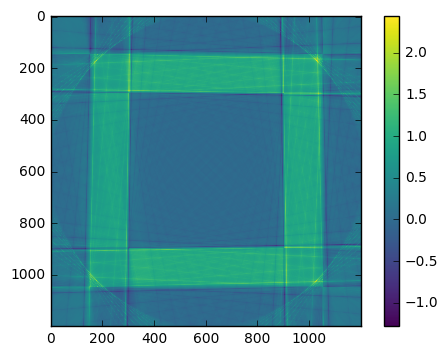

33 23.4811549187
42 25.9842569828
34

In [ ]:
plt.viridis()
t=time.time()
rec_volume,sinogram_volume, angles, proj_geom = test_reconstruction_cone_fdk(
    size=1200, angles_count= 50, gpus_list=[0,1])

print(time.time()-t)
plt.imshow(rec_volume[int(rec_volume.shape[0] / 2),:,:])
plt.colorbar()
plt.show()

# rec_volume[:]=0
rec_volume_tmp = np.memmap('/diskmnt/fast/makov/rec2.tmp',
                       dtype='float32', mode='w+',
                       shape=rec_volume.shape
                       )
t=time.time()
test_reconstruction_cone_sirt(rec_volume, rec_volume_tmp, sinogram_volume, angles, proj_geom, [0,1])
print(time.time()-t)
plt.imshow(rec_volume[int(rec_volume.shape[0] / 2),:,:])
plt.colorbar()
plt.show()

# plt.imshow(rec_volume_tmp[int(rec_volume_tmp.shape[0] / 2),:,:])
# plt.colorbar()
# plt.show()

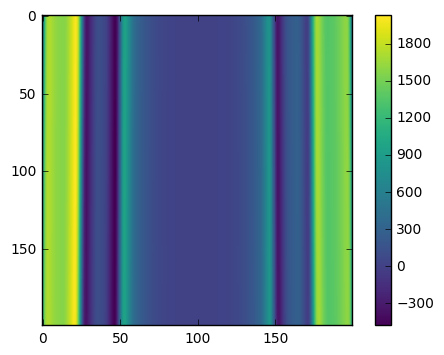

In [221]:
plt.imshow(rec_volume[int(rec_volume.shape[0] / 2),:,:])
plt.colorbar()
plt.show()

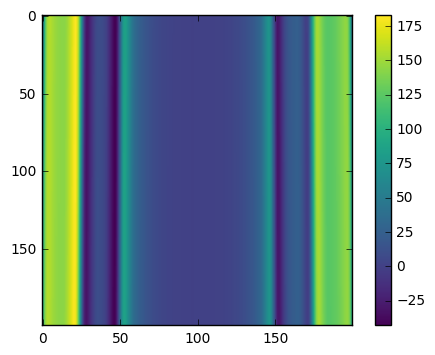

In [222]:
plt.imshow(rec_volume_tmp[int(rec_volume.shape[0] / 2),:,:])
plt.colorbar()
plt.show()

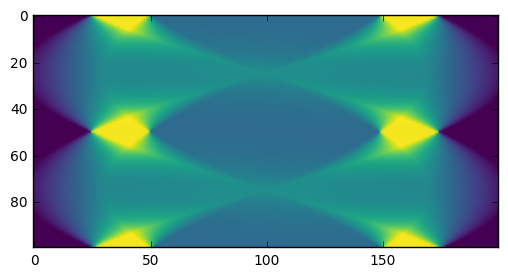

In [173]:
plt.imshow(sinogram_volume[50,:, :])

In [37]:
sinogram_volume[:,:, 100][:,:,np.newaxis].shape

(200, 200, 1)

In [54]:
sinogram_volume.shape

(200, 100, 200)

In [105]:
astra.clear()